# Io AMI Image Deconvolution

In [1]:
import os
# os.chdir("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/amigo/src/amigo")

# autodiff
import jax
from jax import numpy as np
from zodiax.experimental import deserialise

# visualisation
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.transforms import Affine2D
import ehtplot
import scienceplots

# astronomy
import webbpsf

# optimisation
import optax

# AMIGO
import amigo
from amigo.core import AMIOptics, SUB80Ramp, BaseModeller
from amigo.fitting import optimise
from amigo.files import get_files, summarise_files, get_Teffs, get_filters, initialise_params, get_exposures
from amigo.step_mappers import LocalStepMapper
# from amigo.stats import loss_fn

from io_funcs import initialise_disk, SimpleIoSource, ComplexIoSource, HD2236, niriss_parang, get_filter_spectrum
from io_funcs import io_model_fn
from plotting import get_extents, plotting_data_comparison, plot_params, plotting_io_comparison

from optim_funcs import sgd, adam, simple_norm_fn, complex_norm_fn, grad_fn, loss_fn
from optim_funcs import L1_loss, L2_loss, TV_loss, ME_loss, QV_loss
# files
from zodiax.experimental import serialise, deserialise

plt.style.use(['science', 'bright', 'no-latex'])

# matplotlib parameters
%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 8

inferno = colormaps["inferno"]
viridis = colormaps["viridis"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
viridis.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

jax.config.update("jax_enable_x64", True)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-063 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-065
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


dLux: Jax is running in 32-bit, to enable 64-bit visit: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision


# Loading in Io Data
We have five Io exposures to load in, and four calibrator star exposures.

In [2]:
EXP_TYPE = "NIS_AMI"
FILTERS = ["F480M", "F430M", "F380M"]
# TARGPROP = ["HD-37093", "HD-36805"]
# TARGPROP = ["AB-DOR"]

# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    # "/Users/mcha5804/JWST/ERS1373/calgrps/",
    "/Users/mcha5804/JWST/ERS1373/calslope_18/",
    "calslope",
    EXP_TYPE=EXP_TYPE,
    FILTER=FILTERS,
    **kwargs,
)

files = file_fn()

print(f"\n{len(files)}")
summarise_files(
    files,
    [
        # "ACT_ID",
        "APERNAME",
        "PUPIL",
        "SUBARRAY",
        "DETECTOR",
        "EXP_TYPE",
        "NINTS",
        "NGROUPS",
        "TGROUP",
        "OBSERVTN",
        "VISIT",
        "VISITGRP",
        "SEQ_ID",
        "ACT_ID",
        "EXPOSURE",
    ],
)


9
  APERNAME: NIS_AMI1
  PUPIL: NRM
  SUBARRAY: SUB80
  DETECTOR: NIS
  EXP_TYPE: NIS_AMI
  NINTS: 8, 100
  NGROUPS: 18, 12
  TGROUP: 0.07544
  OBSERVTN: 023, 017
  VISIT: 001
  VISITGRP: 03, 04
  SEQ_ID: 1
  ACT_ID: 02
  EXPOSURE: 4, 3, 1, 5, 2


Here we can print out the shapes of the data, and we can see the calibrators have 12 groups and the Io exposures have 45 groups.

In [3]:
nsci = 2
sci_files = []

ncal = 4
cal_files = []

for file in files:
    if file[0].header["TARGPROP"] == "IO":
        sci_files.append(file)
    elif file[0].header["TARGPROP"] == "PSFCAL.2022A-HD2236-K6":
        cal_files.append(file)
    else:
        print(f"Unkown target: {file[0].header['TARGPROP']}")

sci_files = sci_files[:nsci]
cal_files = cal_files[4-ncal:]

for f in sci_files:
    print(f[0].header["TARGPROP"], f[0].header["NGROUPS"], f[1].data.shape)

for f in cal_files:
    print(f[0].header["TARGPROP"], f[0].header["NGROUPS"], f[1].data.shape)

sci_files[0][0].header

IO 18 (17, 80, 80)
IO 18 (17, 80, 80)
PSFCAL.2022A-HD2236-K6 12 (11, 80, 80)
PSFCAL.2022A-HD2236-K6 12 (11, 80, 80)
PSFCAL.2022A-HD2236-K6 12 (11, 80, 80)
PSFCAL.2022A-HD2236-K6 12 (11, 80, 80)


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2024-05-07T04:42:41.317' / UTC date file created                     
ORIGIN  = 'STSCI   '           / Organization responsible for creating file     
TIMESYS = 'UTC     '           / principal time system for time-related keywords
TIMEUNIT= 's       '           / Default unit applicable to all time values     
FILENAME= 'jw01373017001_04102_00003_0001_nis_calslope.fits' / Name of the file 
SDP_VER = '2023_2a '           / Data processing (DP) Software Version          
PRD_VER = 'PRDOPSSOC-063'      / S&OC Project Reference Database (PRD) Version  
OSS_VER = '008.004.011.000'    / Observatory Scheduling Software (OSS) Version  
GSC_VER = 'GSC2431 '        

## Data visualisation
The calslops files (exposures) are of shape $(\text{ngroups - 1}, \text{npix}, \text{npix})$. Since we have up the ramp data, each exposure has $\text{ngroups}$ images, shown in the plot below. The title of the image is the peak pixel brightness of that image. The plot is simply the data from the first exposure. 

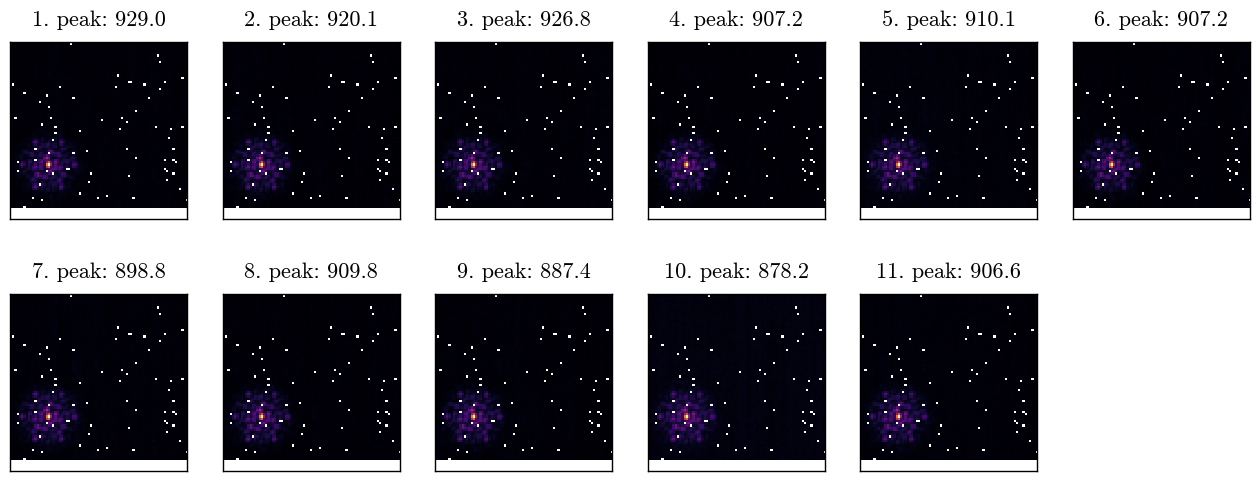

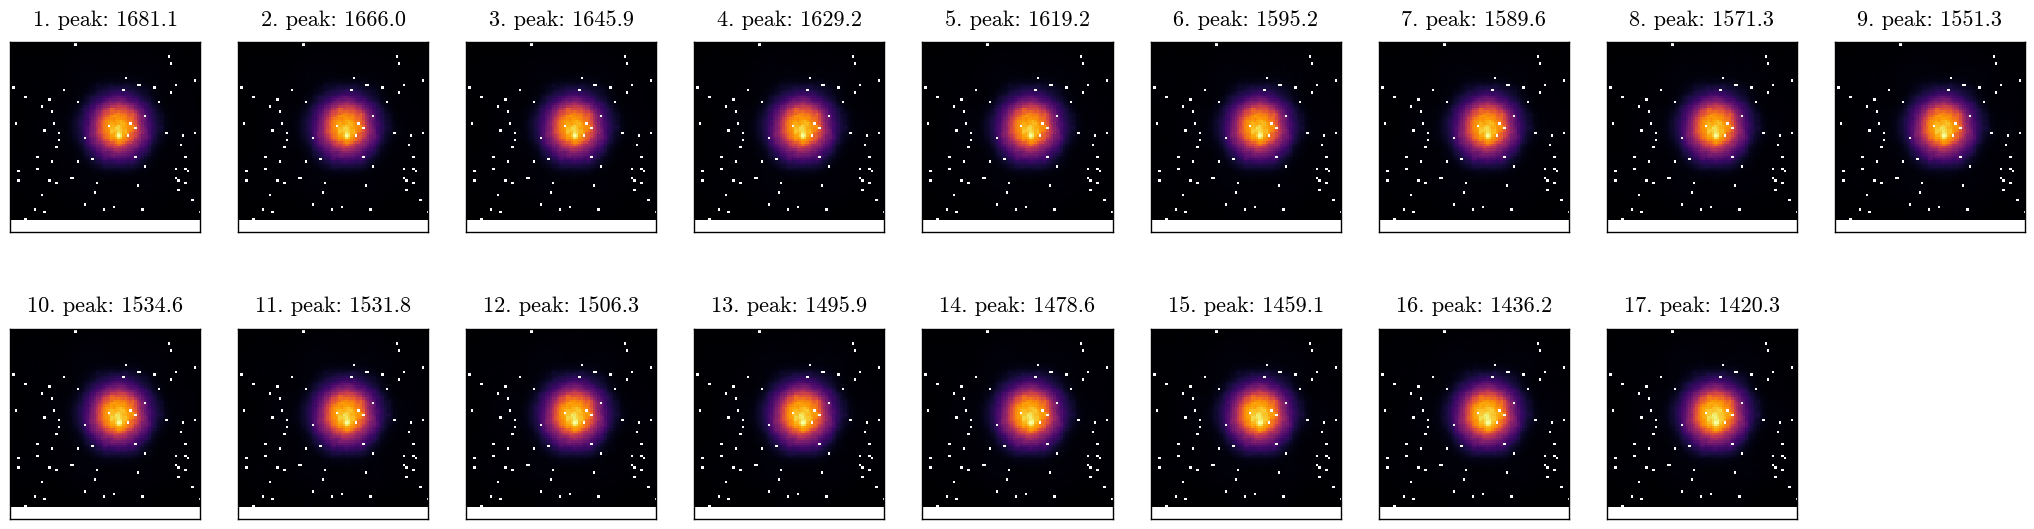

In [4]:
raw_data = np.asarray(cal_files[0][1].data, float)
# data = raw_data - raw_data[0]
cal_data = raw_data

plt.figure(figsize=(8, 3))
for i in range(cal_files[0][1].data.shape[0]):
    plt.subplot(2, 6, i + 1)
    plt.title(f"{i+1}. peak: {np.nanmax(cal_data[i]):.1f}", size=8)
    plt.imshow(cal_data[i])
    plt.xticks([])
    plt.yticks([])
    # plt.colorbar()
plt.show()


raw_data = np.asarray(sci_files[0][1].data, float)
# data = raw_data - raw_data[0]
data = raw_data

plt.figure(figsize=(13, 9))
for i in range(sci_files[0][1].data.shape[0]):
    plt.subplot(5, 9, i + 1)
    plt.title(f"{i+1}. peak: {np.nanmax(data[i]):.1f}", size=8)
    plt.imshow(data[i])
    plt.xticks([])
    plt.yticks([])
    # plt.colorbar()
plt.show()

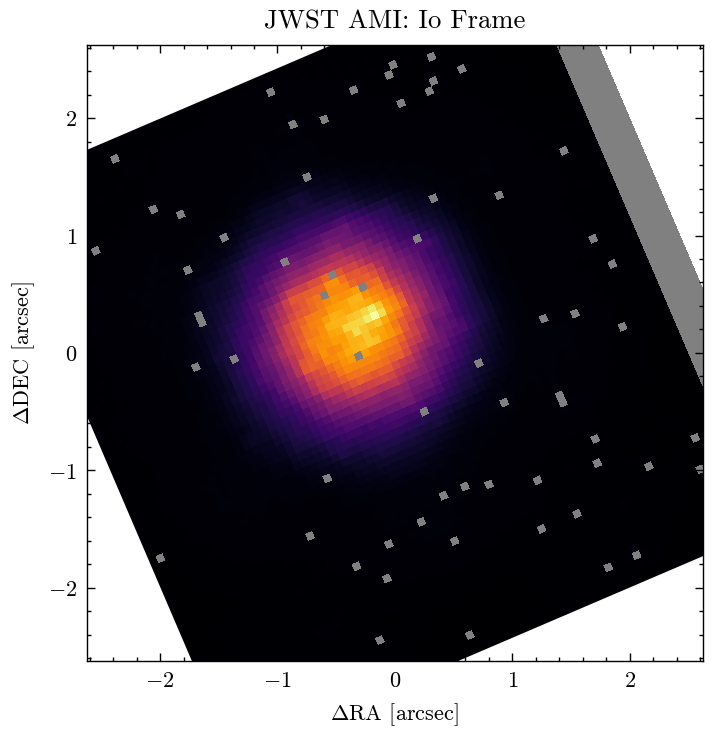

In [5]:
roll_angle = niriss_parang(sci_files[0][1].header)
niriss_pixel_scale = 0.0656  # arcsec/pixel


fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(data[0], **get_extents(data[0], niriss_pixel_scale), cmap=inferno)
trans_data = Affine2D().rotate_deg(-roll_angle) + ax.transData
im.set_transform(trans_data)
ax.set(
    title="JWST AMI: Io Frame",
    xlabel=r"$\Delta$RA [arcsec]",
    ylabel=r"$\Delta$DEC [arcsec]",
)
plt.show()

# Building the model
First I am going to build some custom source classes.

Now we finally build the models. Let's first load in the BFE and mask models.

In [6]:
BFE = deserialise("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/bfe/PolyBFE_trained.zdx")
pupil_mask = deserialise("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/bfe/PolyBFE_AMI_mask.zdx")

And now instantiate and initialise values for the model.

In [16]:
# Get webbpsf optical system for OPD
inst = webbpsf.NIRISS()
inst.load_wss_opd_by_date(files[0][0].header["DATE-BEG"], verbose=False)
opd = np.array(inst.get_optical_system().planes[0].opd)

# Get dLux optical system
optics = AMIOptics(
    opd=opd,
    pupil_mask=pupil_mask,
    # radial_orders=[0, 1, 2, 3],
    normalise=True,
    )

# Get detector and BFE
detector = SUB80Ramp()

# Processing exposures
cal_exposures = get_exposures(cal_files, optics)
cal_params = initialise_params(cal_exposures)

sci_exposures = get_exposures(sci_files, optics)
sci_params = initialise_params(sci_exposures)

filters = get_filters(files)
wavels, weights = filters["F430M"]

cal_params["filters"] = filters; sci_params["filters"] = filters
cal_params["optics"] = optics; sci_params["optics"] = optics
cal_params["detector"] = detector; sci_params["detector"] = detector
cal_params["BFE"] = BFE; sci_params["BFE"] = BFE

# Set log_fluxes
def set_fluxes(exposures, log_flux):
    log_fluxes = {}
    for exp in exposures:
        log_fluxes[exp.key] = log_flux
    return log_fluxes

# Calibrator
cal_params["source"] = HD2236(
    wavelengths=wavels,
    weights=weights,
)
cal_params["Teffs"] = get_Teffs(cal_files)  # TODO find this
# cal_params["log_fluxes"] = set_fluxes(cal_exposures, 5.8)

# Io
uniform_start = np.ones_like(initialise_disk())
uniform_start = np.log10(uniform_start / np.sum(uniform_start))

sci_params["source"] = SimpleIoSource(
    # log_distribution=np.log10(initialise_disk(normalise=True)),
    log_distribution=uniform_start,
    # distribution=canon_io.data,
    spectrum=get_filter_spectrum("F430M", file_path="/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/data/niriss_filters/"),
)
# sci_params["source"] = ComplexIoSource(
#     log_volcanoes=np.log10(initialise_disk(normalise=True)),
#     # distribution=canon_io.data,
#     spectrum=get_filter_spectrum("F430M", file_path="/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/data/niriss_filters/"),
# )
# sci_params["log_fluxes"] = set_fluxes(sci_exposures, 7.0)

# models
initial_model = BaseModeller(sci_params)
cal_model = BaseModeller(cal_params)

Prepping exposures...
Prepping exposures...


In [17]:
initial_model = initial_model.set("BFE.linear", np.zeros_like(BFE.linear))
initial_model = initial_model.set("BFE.quadratic", np.zeros_like(BFE.quadratic))

And finally let's define a model function since we are using the `BaseModeller`.

# Calibrator Fit

In [8]:
# plt.figure(figsize=(6, 5))
# for exp_idx, exp in enumerate(cal_exposures):
#     psf_ramp = model_fn(cal_model, exp)
#     for group_idx in range(4):
#         plt.subplot(4, 5, exp_idx + 5 * group_idx + 1)
#         plt.title(f"Exp {exp_idx}. Peak: {np.nanmax(psf_ramp[group_idx]):.1f}", size=7)
#         plt.imshow(psf_ramp[group_idx])
#         plt.xticks([]); plt.yticks([])
#         # plt.colorbar()
# plt.show()

# plt.figure(figsize=(6, 5))
# for exp_idx, exp in enumerate(cal_exposures):
#     data = exp.data
#     for group_idx in range(4):
#         plt.subplot(4, 5, exp_idx + 5 * group_idx + 1)
#         plt.title(f"Exp {exp_idx}. Peak: {np.nanmax(cal_data[group_idx]):.1f}", size=7)
#         plt.imshow(data[group_idx])
#         plt.xticks([]); plt.yticks([])
#         # plt.colorbar()
# plt.show()

# plt.figure(figsize=(6, 5))
# for exp_idx, exp in enumerate(cal_exposures):
#     data = exp.data
#     psf_ramp = model_fn(cal_model, exp)
#     for i, group_idx in enumerate(np.arange(-2, 2)):
#         residuals, bounds = get_residuals(psf_ramp[group_idx], exp.data[group_idx], return_bounds=True)
#         plt.subplot(4, 5, exp_idx + 5 * i + 1)
#         plt.title(f"Exp{exp_idx}. Grp{group_idx}. Pk: {np.nanmax(psf_ramp[group_idx]):.0f}", size=5)
#         plt.imshow(residuals, **bounds)
#         plt.xticks([]); plt.yticks([])
#         # plt.colorbar()
# plt.show()


## Optimisation

In [10]:
# Calculate local step matrices
cal_local_mappers = []
for exp in cal_exposures:
    cal_local_mappers.append(LocalStepMapper(cal_model, exp))

In [12]:
n_epoch = 30

config = {
    "positions": sgd(5e-1, 0),
    "fluxes": sgd(9e-2, 3),
    "aberrations": sgd(5e-2, 12),
    "one_on_fs": sgd(1e-1, 5),
    
    # BFE
    "BFE.linear": sgd(5e-6, 10),
    "BFE.quadratic": sgd(1e-15, 10),
}

args = {
    "model_fn": io_model_fn,
    "exposures": cal_exposures,
    "step_mappers": cal_local_mappers,
    # "mask": io_mask,
    # "reg_dict": reg_dict,
    # "reg_func_dict": reg_func_dict,
}

cal_final_model, cal_losses, cal_params_out, cal_opt_state = optimise(
    cal_model,
    args,
    loss_fn,
    n_epoch,
    config,
    grad_fn=grad_fn,
    print_grads=False,
    return_state=True,
    nan_method="none",
)

Step fn compiling...
Compile Time: 0:00:22
Initial Loss: 843.72


Loss: 843.72, Change: 0.0:   3%|3         | 1/30 [00:00<?, ?it/s]

Step fn compiling...
Full Time: 0:02:59
Final Loss: 113.78


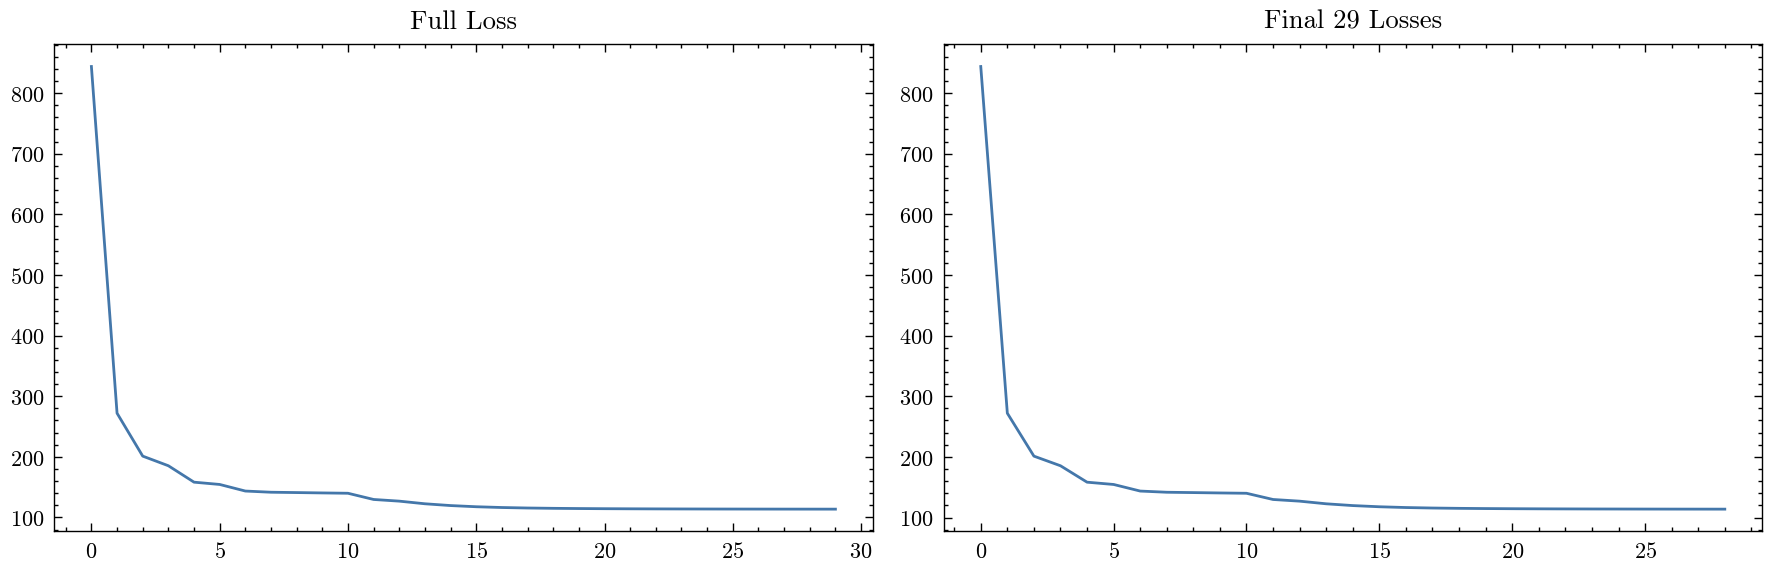

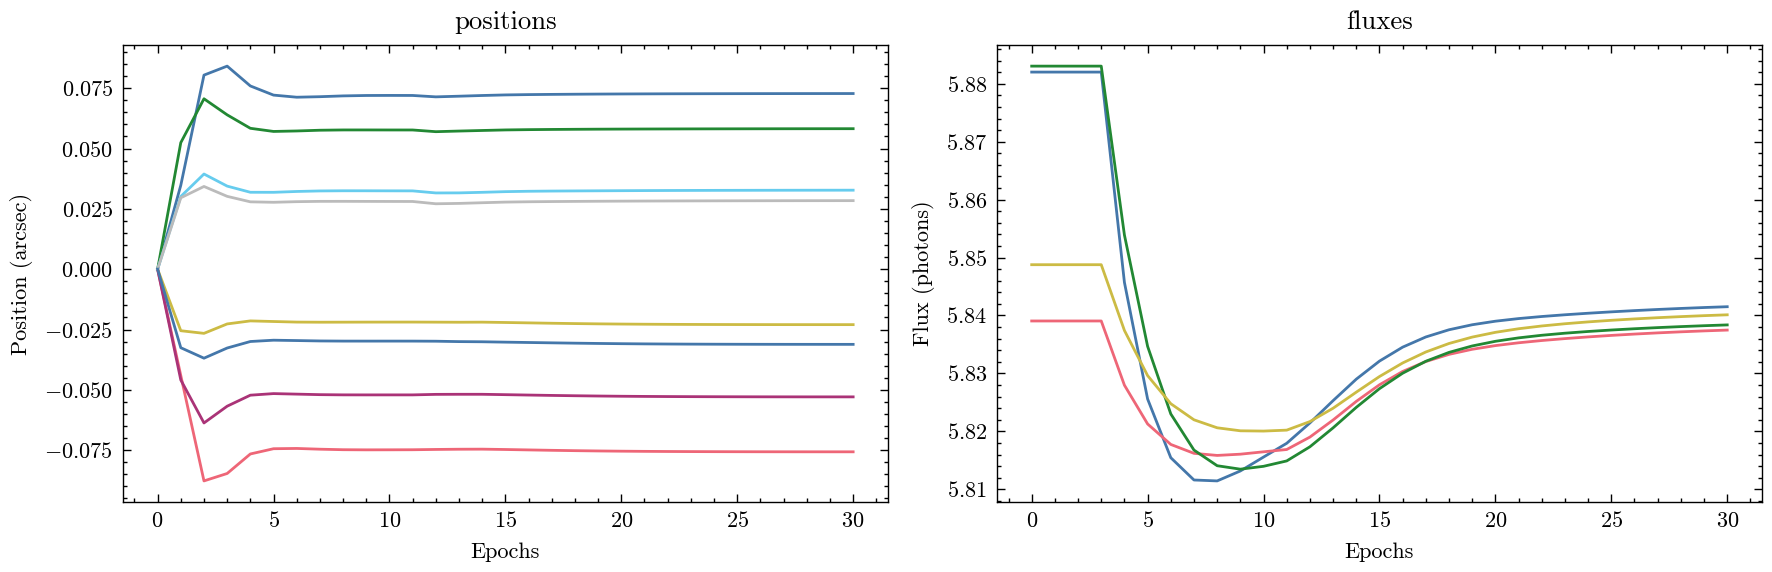

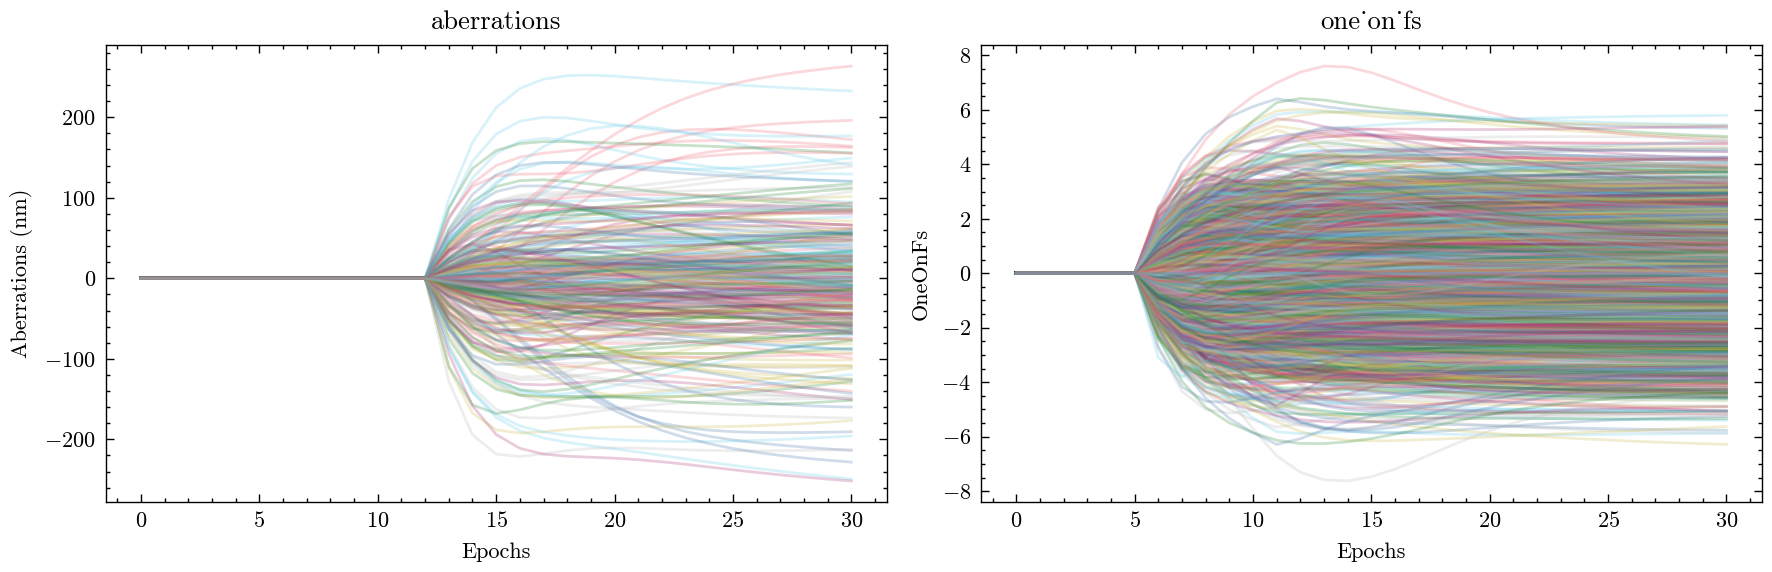

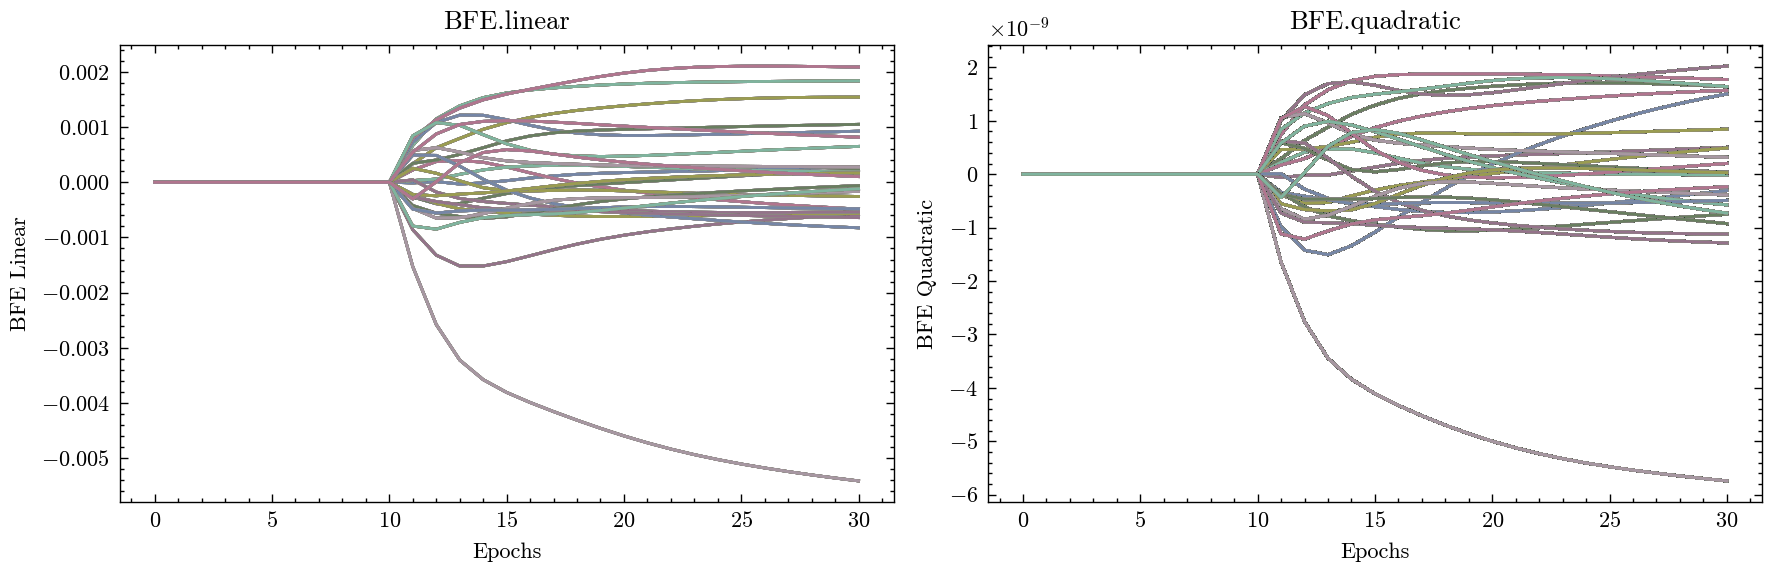

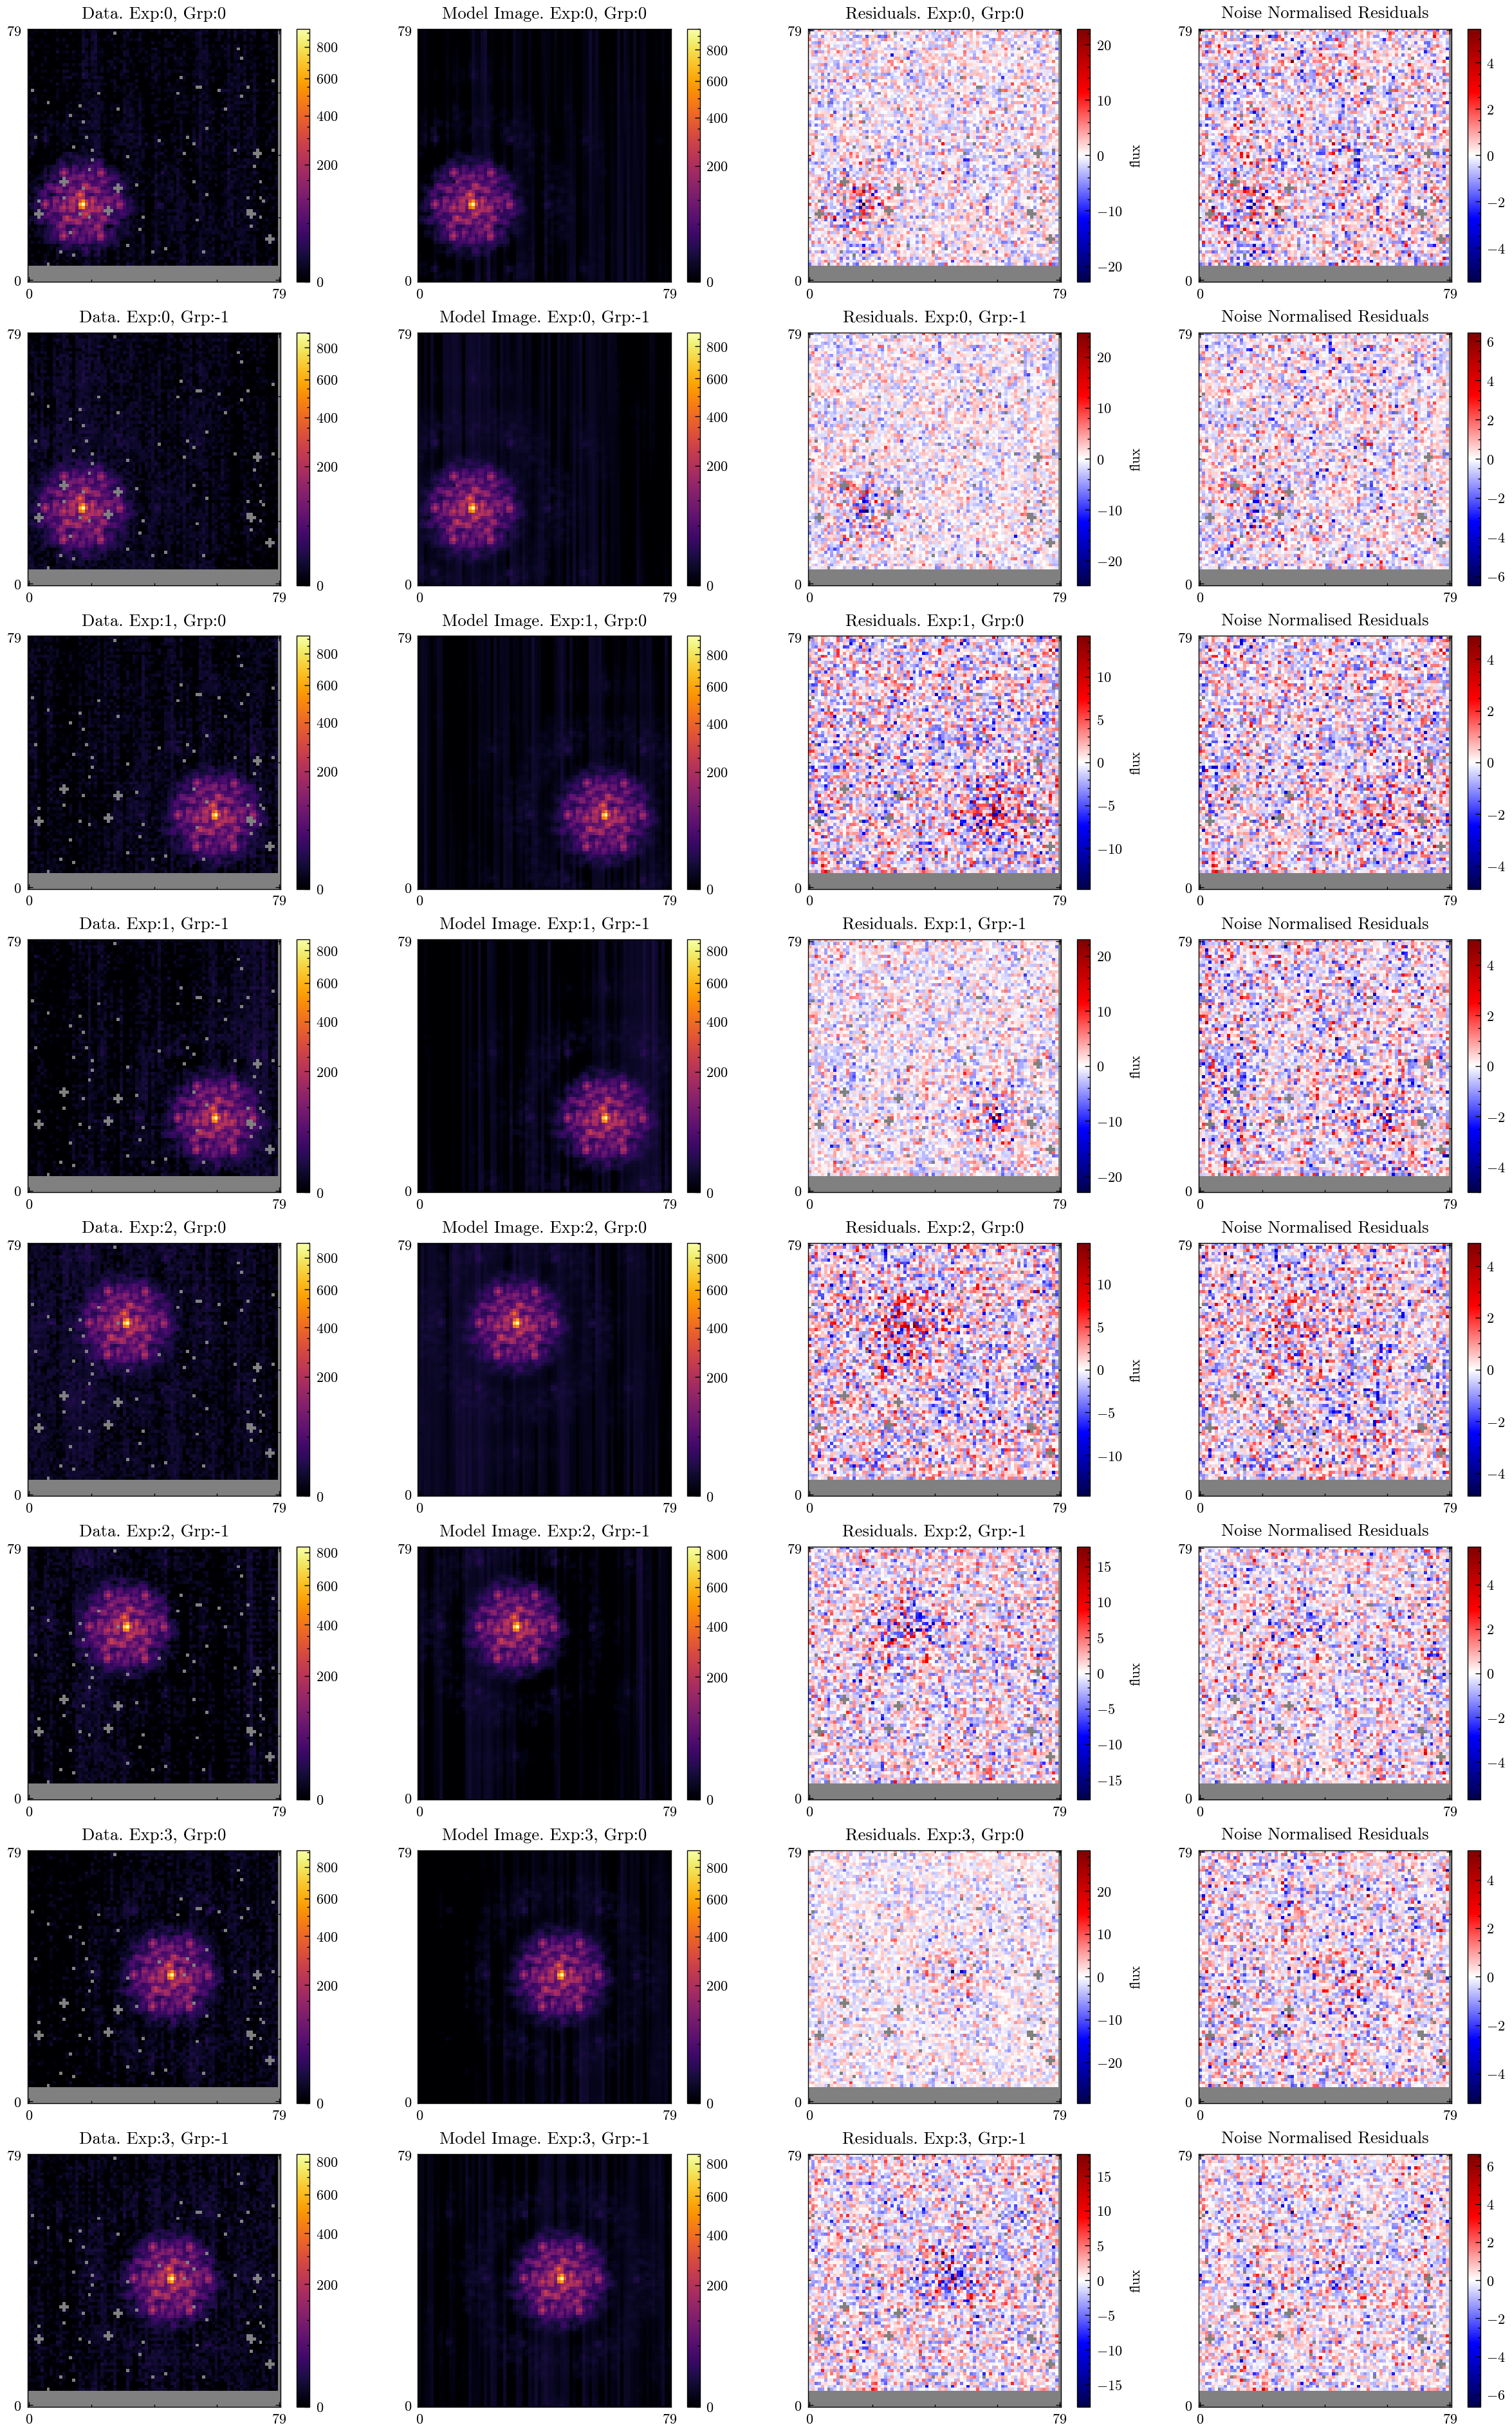

In [13]:
plot_params(np.array(cal_losses), cal_params_out, k=100)
plotting_data_comparison(cal_final_model, cal_exposures, io_model_fn)

In [12]:
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ['_', '.', 'x', '+', '*', 'o', 'v', '^', '<', '>', 's', 'p', 'h', 'D', 'd', '|', '_']

plt.figure(figsize=(5, 5))
for expno, all_abs in enumerate(cal_final_model.aberrations.values()):
    m = markers[expno]
    for mirror_no, mirror_ab in enumerate(all_abs):
        c=colors[mirror_no]
        for noll, noll_abs in enumerate(mirror_ab):
            plt.scatter(noll, noll_abs, color=c, marker=m, alpha=0.7)

plt.xlabel("Noll Index")
plt.xticks(range(10))
plt.grid(axis="x", zorder=-100, linestyle='--', alpha=0.3)
plt.ylabel("Zernike Coefficient (nm)")
plt.title('Comparing Aberrations')
plt.show()

# serialise("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/aberrations.zdx", cal_final_model.aberrations)
# np.save("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/BFE_linear.npy", cal_final_model.BFE.linear)
# np.save("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/BFE_quadratic.npy", cal_final_model.BFE.quadratic)


NameError: name 'cal_final_model' is not defined

<Figure size 1000x1000 with 0 Axes>

# Io

First, let's set the abberations of our Io model to be what we recovered from the calibrator.

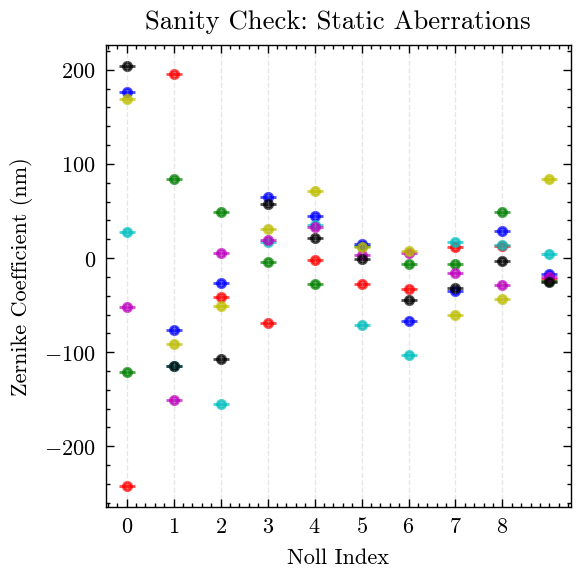

In [18]:
ab_dict = deserialise("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/aberrations.zdx")
# bfe_linear = np.load("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/BFE_linear.npy")
# bfe_quadratic = np.load("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/BFE_quadratic.npy")

colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ['_', '.', 'x', '+', '*', 'o', 'v', '^', '<', '>', 's', 'p', 'h', 'D', 'd', '|', '_']

static_aberrations = []

for abbs in ab_dict.values():
    static_aberrations.append(abbs)

static_aberrations = np.array(static_aberrations).mean(axis=0)

# Setting io BFE coeffs and aberrations to those recovered from calibrator
model = initial_model
for key in initial_model.keys():
    model.aberrations[key] = static_aberrations
# model = model.set(
#     ["BFE.linear", "BFE.quadratic"],
#     [bfe_linear, bfe_quadratic]
# )

initial_distribution = model.distribution

plt.figure(figsize=(3, 3))
for expno, all_abs in enumerate(model.aberrations.values()):
    m = markers[expno]
    for mirror_no, mirror_ab in enumerate(all_abs):
        c=colors[mirror_no]
        for noll, noll_abs in enumerate(mirror_ab):
            plt.scatter(noll, noll_abs, color=c, marker=m, alpha=0.7)

plt.xlabel("Noll Index")
plt.xticks(range(9))
plt.grid(axis="x", zorder=-100, linestyle='--', alpha=0.3)
plt.ylabel("Zernike Coefficient (nm)")
plt.title('Sanity Check: Static Aberrations')
plt.show() 

## Visualisation

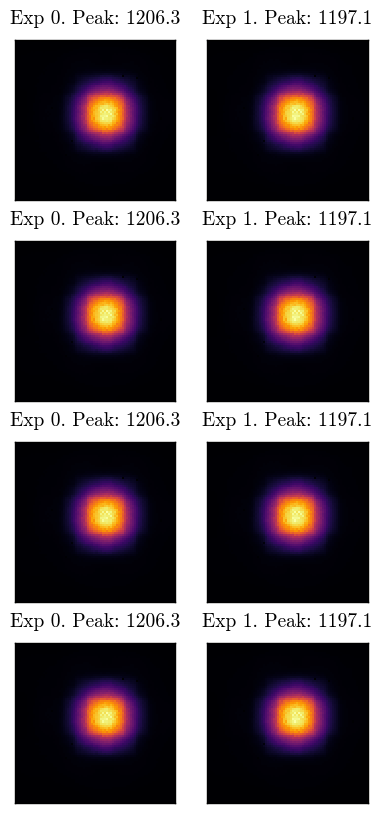

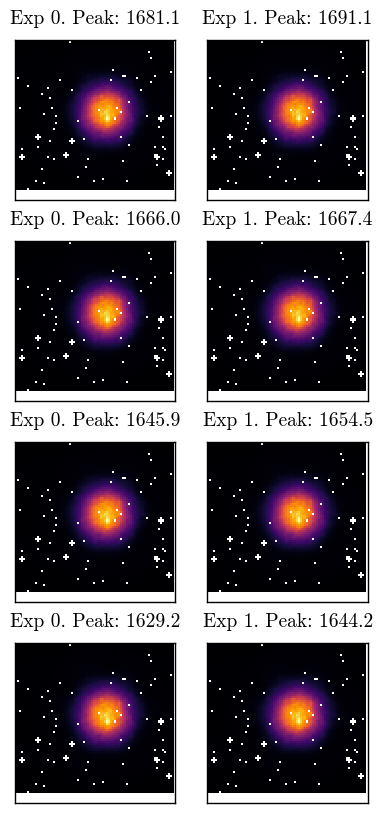

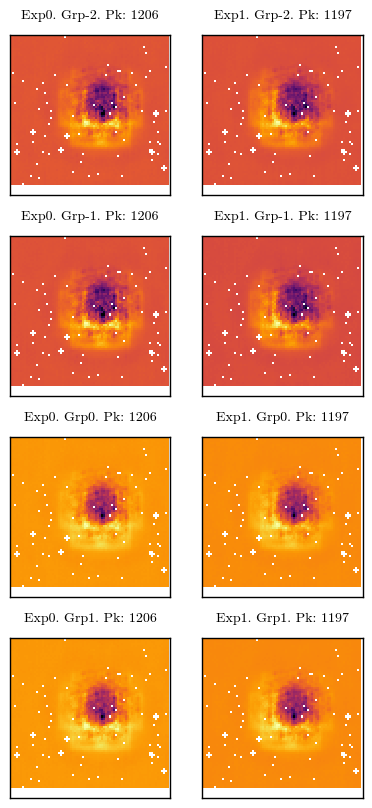

In [19]:
plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(sci_exposures):
    psf_ramp = io_model_fn(model, exp)
    for group_idx in range(4):
        plt.subplot(4, 5, exp_idx + 5 * group_idx + 1)
        plt.title(f"Exp {exp_idx}. Peak: {np.nanmax(psf_ramp[group_idx]):.1f}", size=7)
        plt.imshow(psf_ramp[group_idx])
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()


plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(sci_exposures):
    data = exp.data
    for group_idx in range(4):
        plt.subplot(4, 5, exp_idx + 5 * group_idx + 1)
        plt.title(f"Exp {exp_idx}. Peak: {np.nanmax(data[group_idx]):.1f}", size=7)
        plt.imshow(data[group_idx])
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()

plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(sci_exposures):
    data = exp.data
    psf_ramp = io_model_fn(model, exp)
    for i, group_idx in enumerate(np.arange(-2, 2)):
        plt.subplot(4, 5, exp_idx + 5 * i + 1)
        plt.title(f"Exp{exp_idx}. Grp{group_idx}. Pk: {np.nanmax(psf_ramp[group_idx]):.0f}", size=5)
        plt.imshow(psf_ramp[group_idx] - data[group_idx])
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()


# Optimisation

In [20]:
# Calculate local step matrices
sci_local_mappers = []
for exp in sci_exposures:
    sci_local_mappers.append(LocalStepMapper(model, exp, io_model_fn))

Main Time: 152.67
Noise Time: 16.88
Main Time: 152.80
Noise Time: 17.19


In [62]:
n_epoch = 30

reg_dict = {
    # "L1": 1.e0,
    # "L2": 1.e1,
    # "TV": 2.e1,
    # "QV": 3.e1,
    "ME": 1e0, 
}

reg_func_dict = {
    "L1": L1_loss,
    "L2": L2_loss,
    "TV": TV_loss,
    "QV": QV_loss,
    "ME": ME_loss,
}

args = {
    "model_fn": io_model_fn,
    "exposures": sci_exposures,
    # "step_mappers": local_mappers,
    # "mask": io_mask,
    "reg_dict": reg_dict,
    "reg_func_dict": reg_func_dict,
    }

config = {
    "positions": sgd(1e-6, 0),
    "fluxes": sgd(5e-7, 2),
    "log_distribution": adam(1.5e-1, 4, (20, 0.5), b1=0.7),
    # "volc_frac": adam(5e-2, 5, b1=0.7),
    # "log_volcanoes": adam(5e-1, 2, (6, 0.3), b1=0.7),
    # "aberrations": sgd(0*1e-2, 9),
    # "one_on_fs": sgd(0*2e-1, 5),
    # "optics.coefficients": opt(1e3, 10),
}

# params = list(config.keys())

# Optimisation
final_model, losses, params_out, opt_state = optimise(
    model,
    args,
    loss_fn,
    n_epoch, 
    config,
    # norm_fn=complex_norm_fn,
    norm_fn=simple_norm_fn,
    # grad_fn=grad_fn,
    print_grads=False,
    return_state=True,
    nan_method="none",
)

Step fn compiling...
Compile Time: 0:00:13
Initial Loss: 6,363.50


Loss: 6,363.50, Change: 0.0:   3%|3         | 1/30 [00:00<?, ?it/s]

Full Time: 0:02:08
Final Loss: 239.10


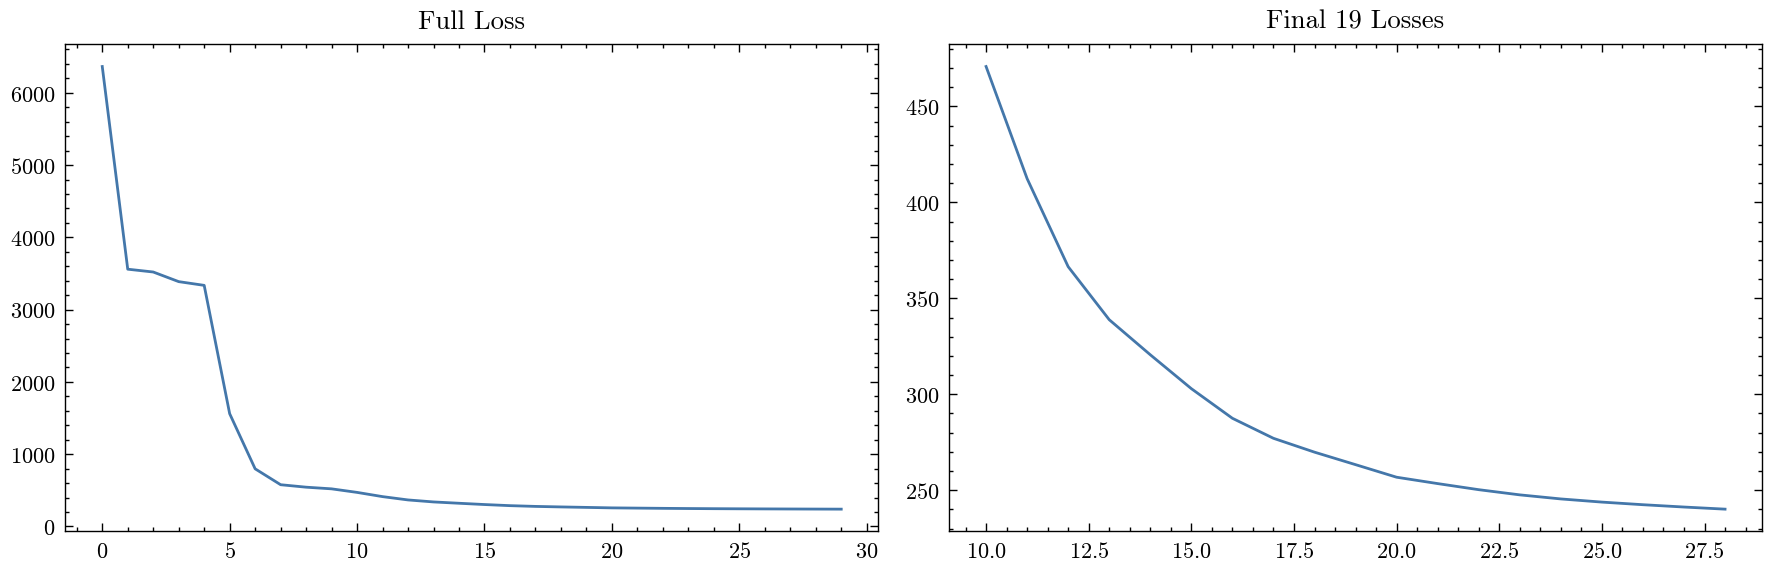

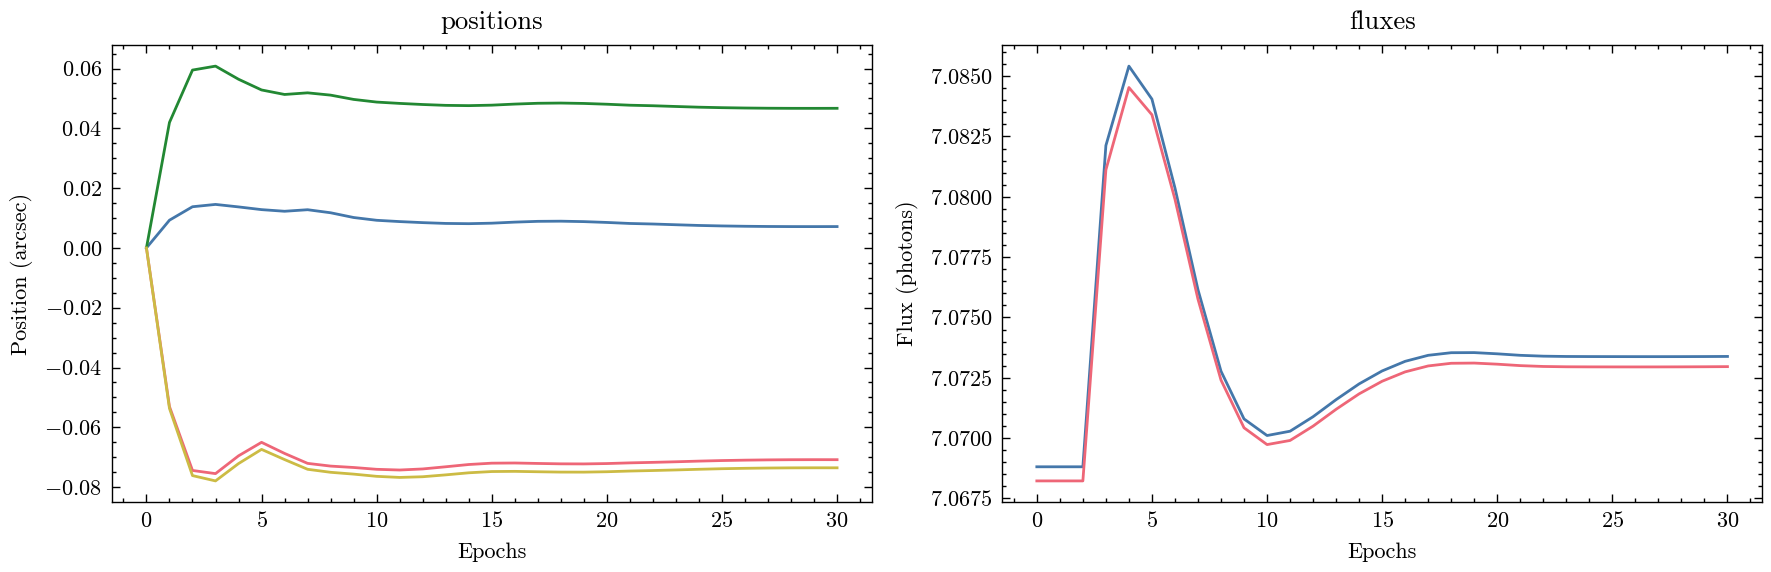

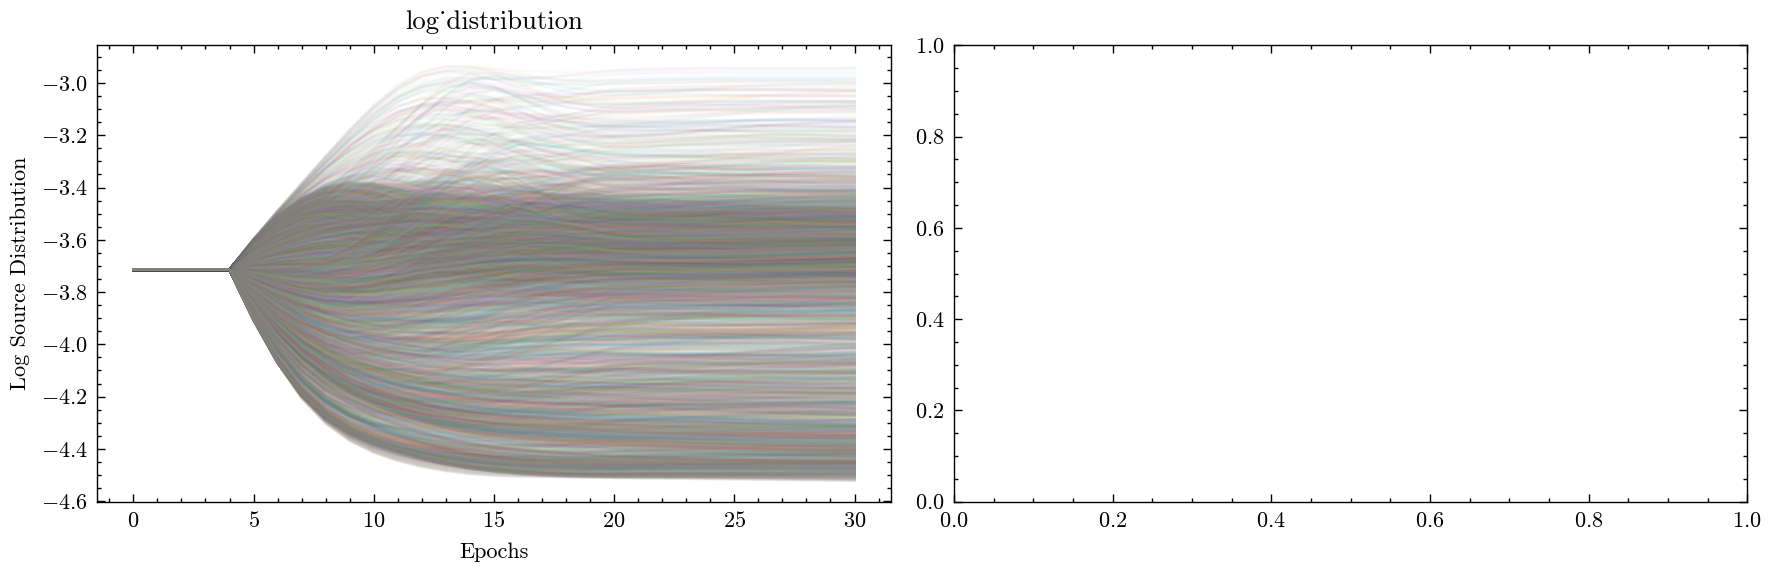

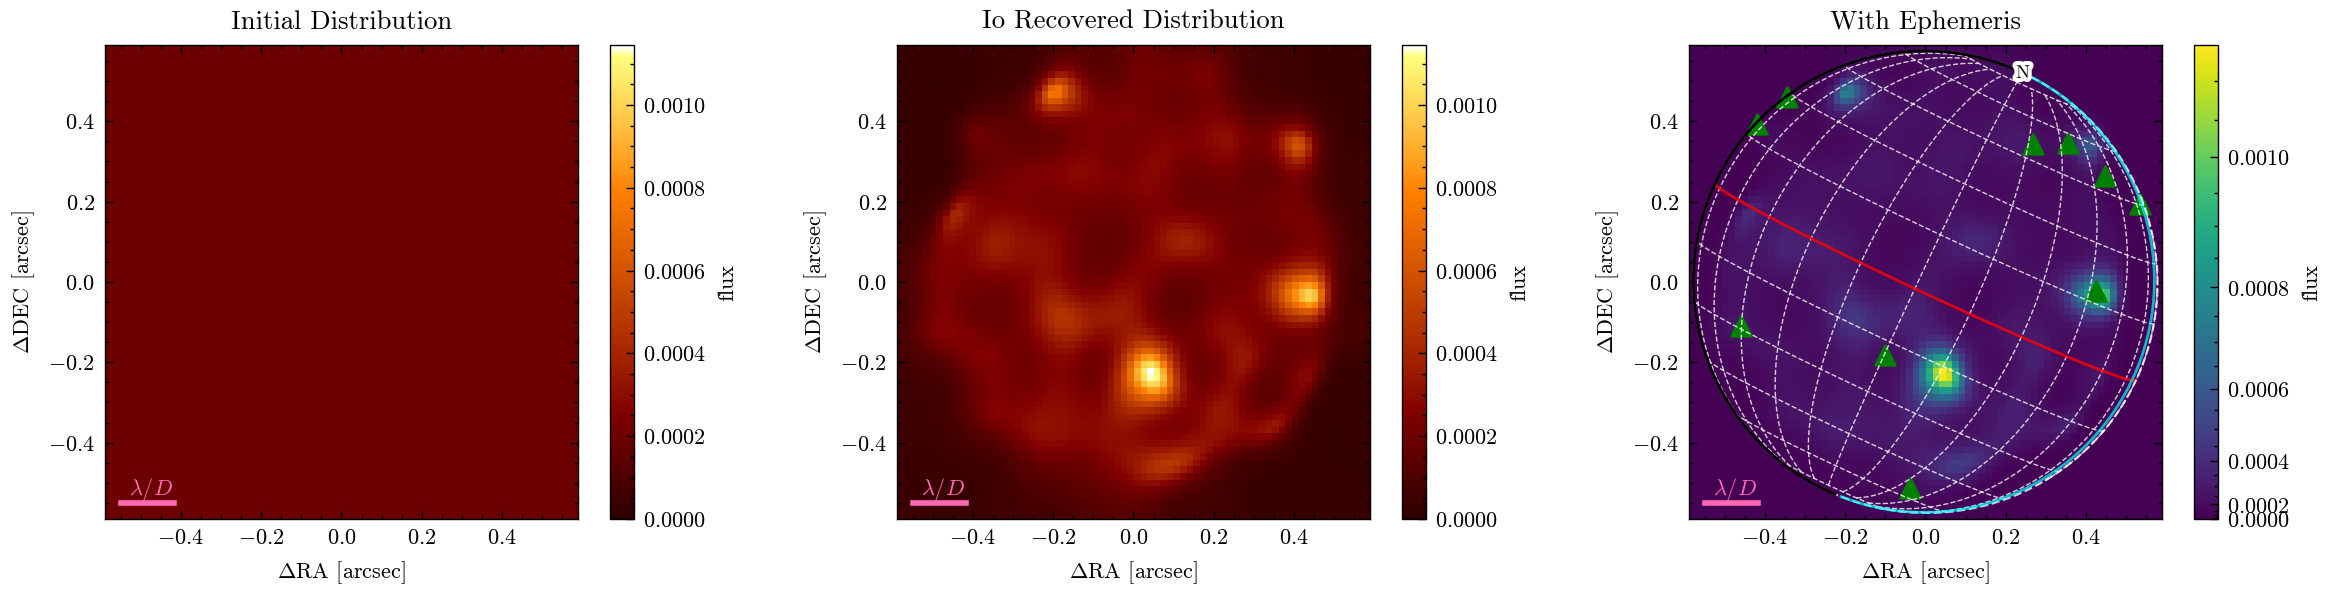

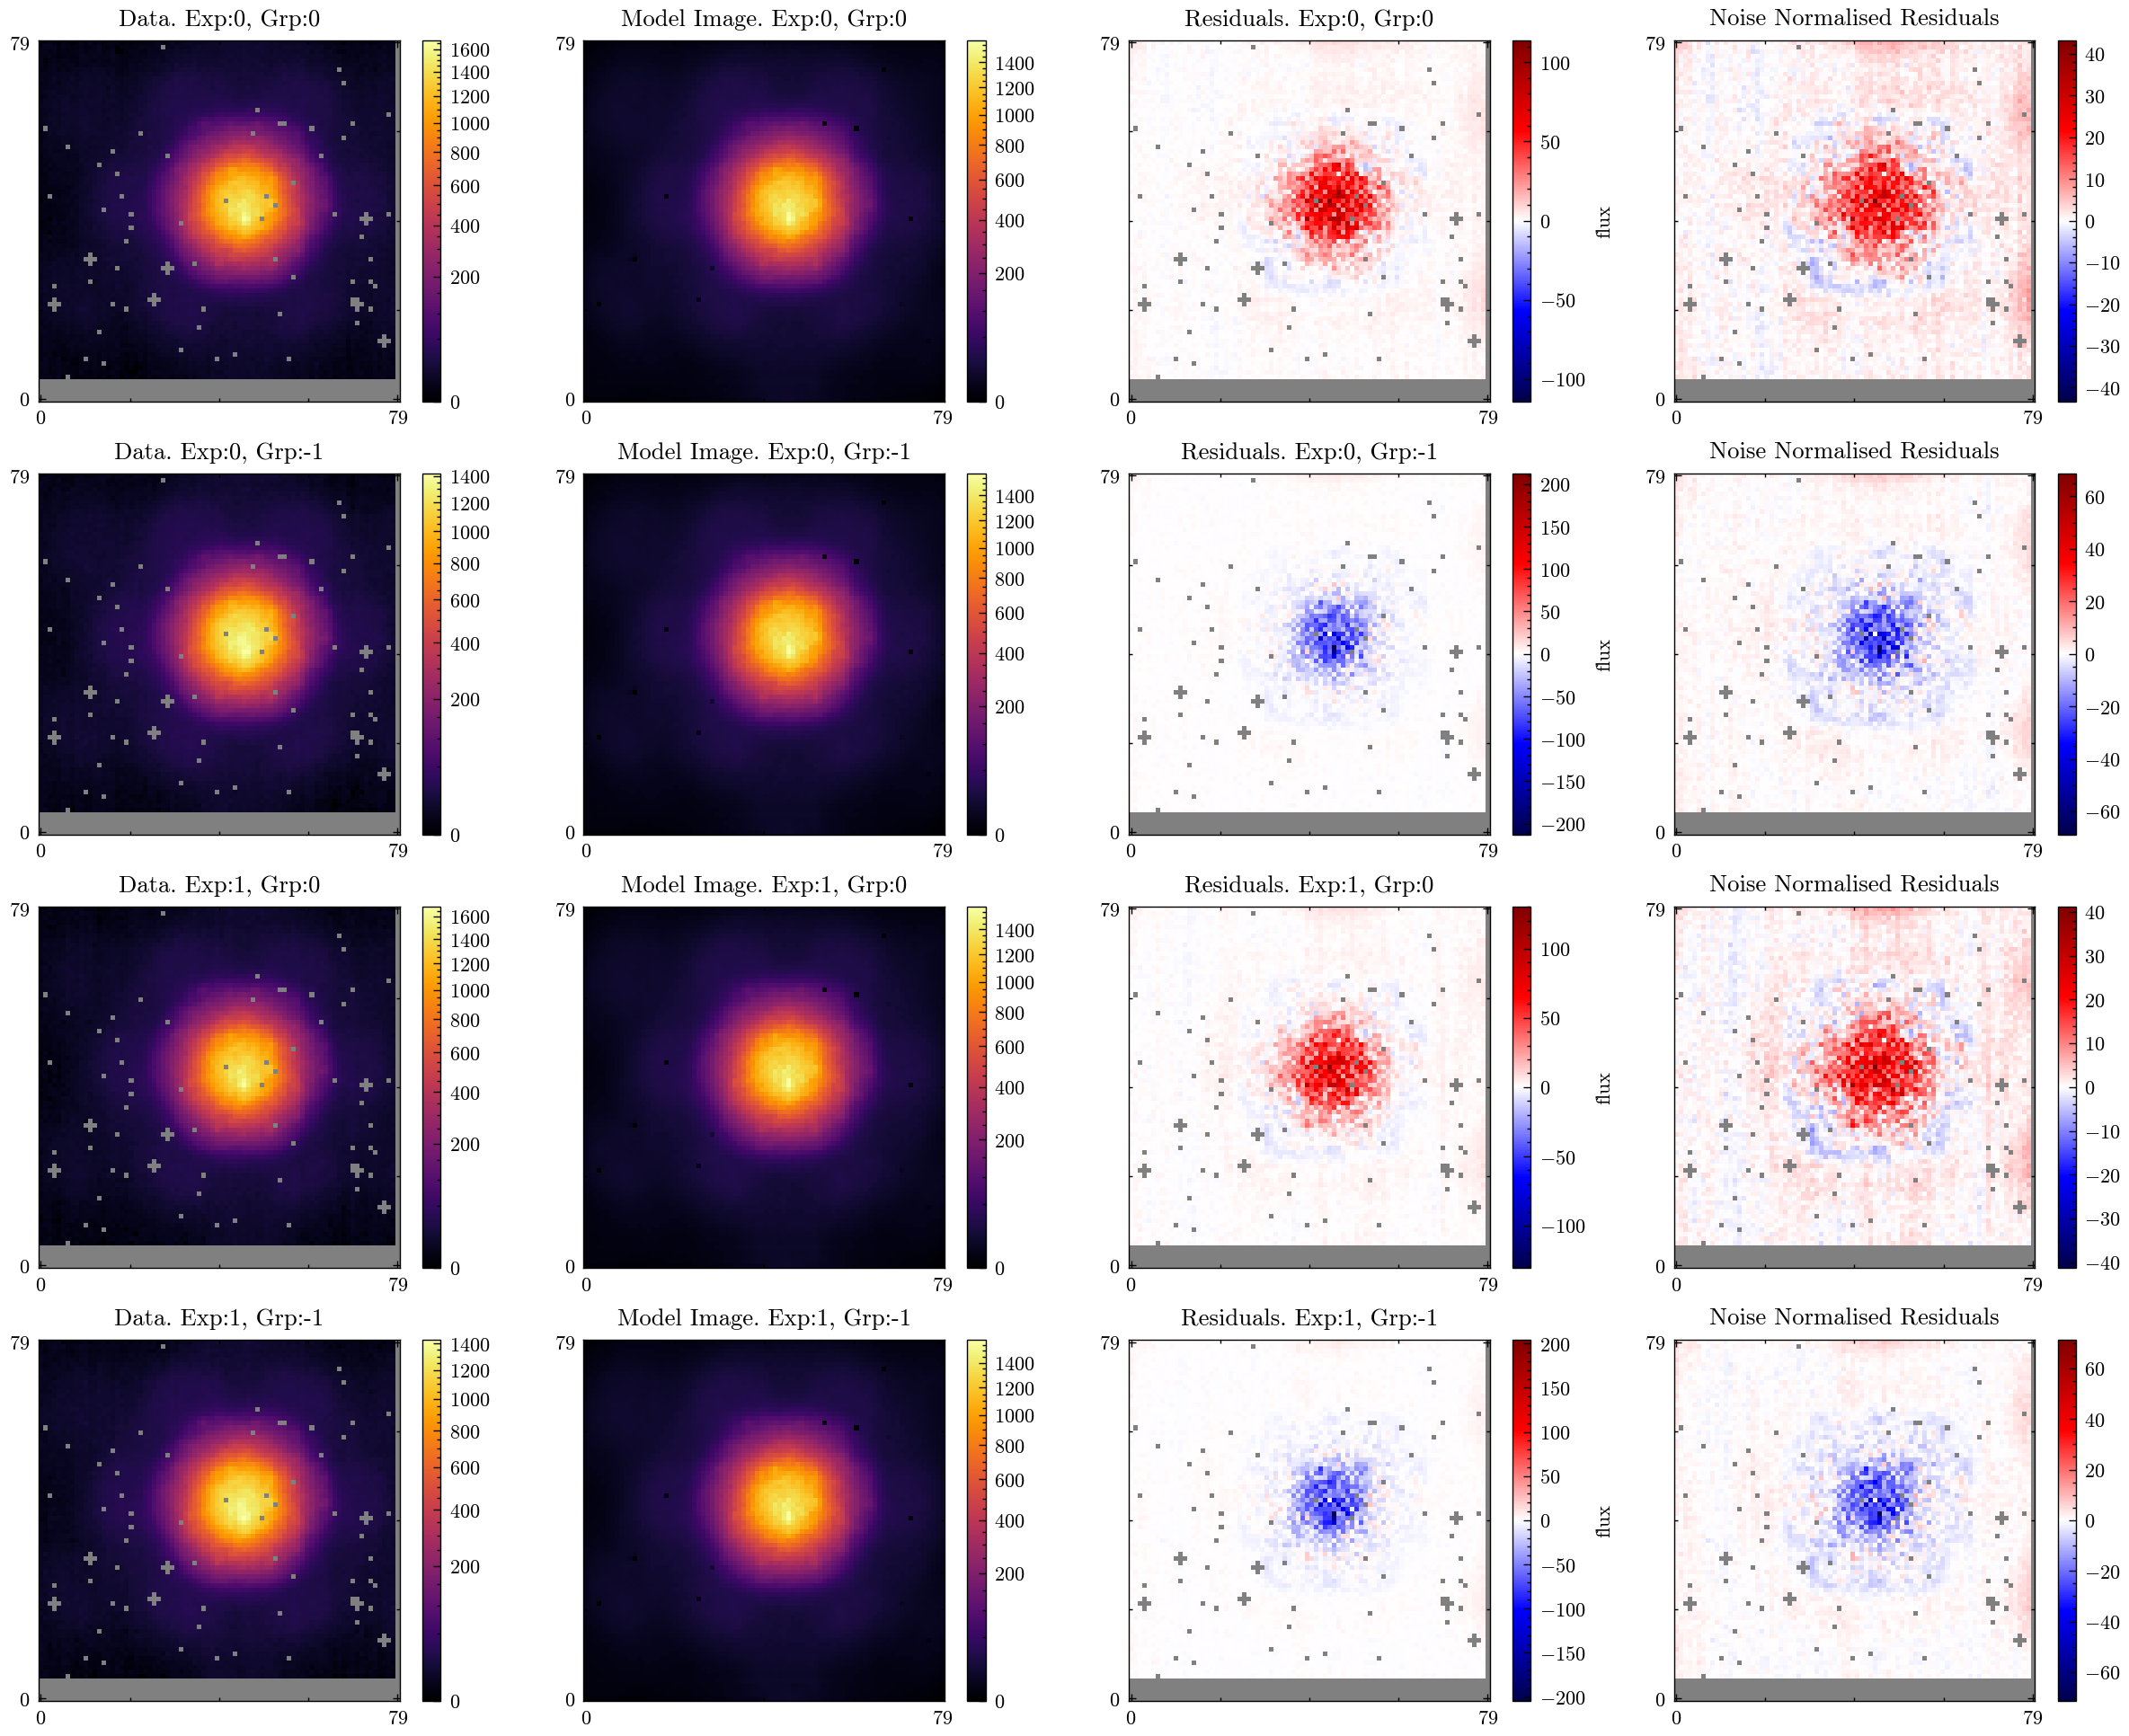

In [63]:
ngrps = sci_files[0][0].header["NGROUPS"]
plot_params(np.array(losses), params_out, save=None)
plotting_io_comparison(
    final_model,
    initial_distribution=initial_distribution,
    # roll_angle_degrees=roll_angle,
    power=1.,
    io_max=np.max(final_model.distribution),
    eph_cmap="viridis",
    )
plotting_data_comparison(final_model, sci_exposures, io_model_fn, power=.5)



In [60]:
from plotting import get_residuals, get_residual_bounds
save_dir = "gifs/uniform_ramp/"

hmm = io_model_fn(final_model, sci_exposures[0])

ims = []
for i in range(hmm.shape[0]):
    fig, ax = plt.subplots(1, 2, figsize=(7.5, 3))
    
    # plt.subplot(1, 3, 1)
    # plt.imshow(hmm[i])

    # plt.subplot(1, 3, 2)
    # plt.imshow(sci_exposures[0].data[i])

    res, bd = get_residuals(sci_exposures[0].data[i], hmm[i], return_bounds=True)
    nnim = res / np.sqrt(exp.variance[i])
    bound_dict = get_residual_bounds(nnim)

    if i==0:
        yo = bd
        yoo = bound_dict
    # plt.subplot(1, 3, 3)
    c0 = ax[0].imshow(res, **yo)
    fig.colorbar(c0)
    ax[0].set(
        title = f"Group {i+1} - {i}, Residuals",
    )

    c1 = ax[1].imshow(nnim, **yoo)
    fig.colorbar(c1)
    ax[1].set(
        title = f"Noise Normalised Residuals",
        )
    plt.tight_layout()
    # plt.show()
    plt.savefig(f"{save_dir}resid_{i:02d}.png", dpi=300)
    plt.close()

In [61]:
import os
from PIL import Image

# Create and save a gif using the images in "save_dir" using Pillow

# Get the list of image files in the save directory
image_files = sorted([f for f in os.listdir(save_dir) if f.endswith(".png")])

# Create a list to store the frames of the gif
frames = []
# Iterate over the image files and add each image to the frames list
for image_file in image_files:
    image_path = os.path.join(save_dir, image_file)
    image = Image.open(image_path)
    frames.append(image)

# Save the frames as a gif
gif_path = save_dir + "animation.gif"
frames[0].save(gif_path, format="GIF", append_images=frames[1:], save_all=True, duration=400, loop=0)

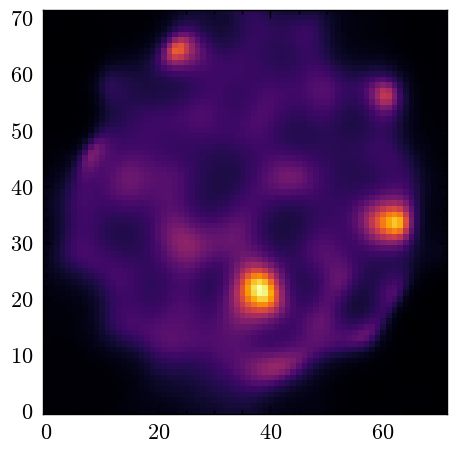